In [101]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import mean_squared_error, mutual_info_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt

In [3]:
data = "https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv"
!wget $data

--2023-10-07 20:08:23--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1475504 (1.4M) [text/plain]
Saving to: ‘data.csv.2’

data.csv.2          100%[===================>]   1.41M  --.-KB/s    in 0.04s   

2023-10-07 20:08:23 (35.6 MB/s) - ‘data.csv.2’ saved [1475504/1475504]



# Data prep

In [41]:
df = pd.read_csv("data.csv")

In [42]:
df_cols = [
    "Make",
    "Model",
    "Year",
    "Engine HP",
    "Engine Cylinders",
    "Transmission Type",
    "Vehicle Style",
    "highway MPG",
    "city mpg",
    "MSRP",
    ]

In [43]:
def tweak_df(table: pd.DataFrame) -> pd.DataFrame:
    table = table.loc[:, df_cols].copy()
    table.columns = table.columns.str.replace(' ', '_').str.lower()
    table = (table
        .rename(columns={"msrp": "price"})
        .fillna(0)
        )
    return table

In [44]:
df = tweak_df(df)

In [45]:
df["above_average"] = (df["price"] > df["price"].mean()).astype(int)

In [46]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [47]:
df_train.shape[0] + df_val.shape[0] + df_test.shape[0] == df.shape[0]

True

In [48]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

del df_train['price'], df_train['above_average']
del df_val['price'], df_val['above_average']
del df_test['price'], df_test['above_average']

# Question 1: ROC AUC feature importance
ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

For each numerical variable, use it as score and compute AUC with the above_average variable
Use the training dataset for that

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['engine_hp'])

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

* engine_hp
* engine_cylinders
* highway_mpg
* city_mpg

In [61]:
numerical = list(df_train.select_dtypes('number'))
categorical = list(df_train.select_dtypes('object'))

In [62]:
dv = DictVectorizer(sparse=False)

In [63]:
train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

In [70]:
from sklearn.metrics import auc

In [139]:
numerical

['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']

In [141]:
for c in numerical:
    auc_score = roc_auc_score(df_train['above_average'], df_train[c])
    print(f"The AUC for {c} is {auc_score:.4f}")
    print("\n")


The AUC for year is 0.6928


The AUC for engine_hp is 0.9165


The AUC for engine_cylinders is 0.7672


The AUC for highway_mpg is 0.3683


The AUC for city_mpg is 0.3277




In [142]:
print("The engine_hp variable has the highest AUC.")

The engine_hp variable has the highest AUC.


# Question 2: Training the model
Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
What's the AUC of this model on the validation dataset? (round to 3 digits)

* 0.678
* 0.779
* 0.878
* 0.979

In [71]:
model = LogisticRegression(solver='liblinear', C=10, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(C=10, max_iter=1000, solver='liblinear')

In [73]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
value_above_average = (y_pred >= 0.5)
(y_val == value_above_average).mean()

0.9353755770037767

In [76]:
from sklearn.metrics import roc_auc_score

In [87]:
auc_score = roc_auc_score(y_val, y_pred)
print(f"The AUC for this model is {auc_score:.4f}")

The AUC for this model is 0.9796


# Question 3: Precision and Recall
Now let's compute precision and recall for our model.

Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01

For each threshold, compute precision and recall

Plot them

At which threshold precision and recall curves intersect?

* 0.28
* 0.48
* 0.68
* 0.88

In [97]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [99]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)

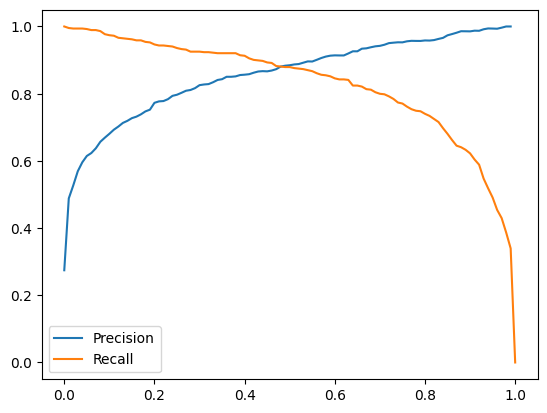

In [102]:
plt.plot(df_scores.threshold, df_scores['precision'], label='Precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='Recall')
plt.legend()

In [103]:
print("The Precision and Recall Curves intersect at 0.48 threshold.")

The Precision and Recall Curves intersect at 0.48 threshold.


# Question 4: F1 score
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:
$$
F_1=2.\frac{P.R}{P+R}
$$
Where *P* is precision and *R* is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

* 0.12
* 0.32
* 0.52
* 0.72

In [110]:
def f1(precision, recall):
    score = 2*(precision*recall)/(precision+recall)
    return score

df_scores = df_scores.assign(f1=lambda _df: f1(_df['precision'], _df['recall']))

In [121]:
df_scores[['threshold', 'f1']].sort_values(by='f1', ascending=False)

,threshold,f1
38,0.38,0.884644
36,0.36,0.883994
37,0.37,0.883994
39,0.39,0.883962
40,0.40,0.883790
...,...,...
97,0.97,0.600427
98,0.98,0.557883
99,0.99,0.506849
0,0.00,0.430688


In [122]:
print("The F! is maximal at 0.32 threshold.")

The F! is maximal at 0.32 threshold.


# Question 5: 5-Fold CV
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)

Iterate over different folds of df_full_train

Split the data into train and validation

Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

Use AUC to evaluate the model on validation

How large is standard devidation of the scores across different folds?

* 0.003
* 0.030
* 0.090
* 0.140

In [124]:
from sklearn.model_selection import KFold
%pip install tqdm
from tqdm.auto import tqdm

  Obtaining dependency information for tqdm from https://files.pythonhosted.org/packages/00/e5/f12a80907d0884e6dff9c16d0c0114d81b8cd07dc3ae54c5e962cc83037e/tqdm-4.66.1-py3-none-any.whl.metadata
  Using cached tqdm-4.66.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.66.1-py3-none-any.whl (78 kB)
Note: you may need to restart the kernel to use updated packages.


/home/gitpod/.pyenv/versions/3.11.5/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [129]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [131]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [132]:
n_splits = 5

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.above_average.values
    y_val = df_val.above_average.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.979 +- 0.002


In [133]:
print("The standard deviation across the different folds is 0.002.")

The standard deviation across the different folds is 0.002.


# Question 6: Hyperparemeter Tuning
Now let's use 5-Fold cross-validation to find the best parameter C

Iterate over the following C values: [0.01, 0.1, 0.5, 10]

Initialize KFold with the same parameters as previously

Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)

Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?

* 0.01
* 0.1
* 0.5
* 10

In [136]:
n_splits = 5

for C in tqdm([0.01, 0.1, 0.5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.above_average.values
        y_val = df_val.above_average.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

 25%|██▌       | 1/4 [00:01<00:04,  1.39s/it]

C=0.01 0.952 +- 0.003


 50%|█████     | 2/4 [00:02<00:02,  1.46s/it]

C=0.1 0.972 +- 0.002


 75%|███████▌  | 3/4 [00:04<00:01,  1.48s/it]

C=0.5 0.977 +- 0.002


100%|██████████| 4/4 [00:06<00:00,  1.51s/it]

C=10 0.981 +- 0.003


In [137]:
print("C equals to 10 leads tothe besst mean score.")

C equals to 10 leads tothe besst mean score.
